In [1]:
import pickle
import torch
import sys
sys.path.append("..") 
from custom_data import create_custom_dataset

custom_data = create_custom_dataset()
with open("../outputs/activations_exaone_8b_train_synthetic.pkl", "rb") as f:
    activations = pickle.load(f)
print(activations.keys())
big_categories = list(set([custom_data[i]['big_category'] for i in range(len(custom_data))]))
small_categories = list(set([custom_data[i]['small_category'] for i in range(len(custom_data))]))
big_category_indices = {big_category: [] for big_category in big_categories}
small_category_indices = {small_category: [] for small_category in small_categories}

for i, data in enumerate(custom_data):
    big_category_indices[data['big_category']].append(i)
    small_category_indices[data['small_category']].append(i)

dict_keys(['synthetic_input_ids', 'synthetic_residual_q2', 'synthetic_residual_q3'])


In [2]:
import torch 
import pickle
from tqdm import tqdm
from nlp_features.sae.standard_sae import AutoEncoder
from nlp_features.sae.gated_sae import GatedAutoEncoder

activations_path = "../outputs"
activations_lang = "synthetic"
lang ="ko"
activation_name = f"exaone_8b_train_{activations_lang}"
name = f"exaone_8b_train_{lang}"
q = 2 
sae= 'gated'
path = f"{activations_path}/sae/{sae}/{name}_q{q}"

activations = pickle.load(open(f'{activations_path}/activations_{activation_name}.pkl', 'rb'))
act = activations[f'{activations_lang}_residual_q{q}']   

if sae == 'standard':
    ae = AutoEncoder.from_pretrained(f"{path}/model.pth")
elif sae == 'gated':
    ae = GatedAutoEncoder.from_pretrained(f"{path}/model.pth")

In [3]:
activations.keys()

dict_keys(['synthetic_input_ids', 'synthetic_residual_q2', 'synthetic_residual_q3'])

In [4]:
def get_feature_counts(sae, num_dictionary, activations):
    n_samples = len(activations)
    feature_counts = torch.zeros(n_samples, num_dictionary)
    for s in tqdm(range(n_samples)):
        sample = activations[s].to('cuda')
        reconstructed_activations, features = sae(sample, output_features=True)
        feature_counts[s] = torch.sum(features, dim=0).detach().cpu()
    return feature_counts

ae.to('cuda')
num_dictionary = ae.dict_size 
feature_counts = get_feature_counts(ae, num_dictionary, act)


100%|██████████| 1500/1500 [00:18<00:00, 82.13it/s]


In [5]:
feature_counts.shape

torch.Size([1500, 100000])

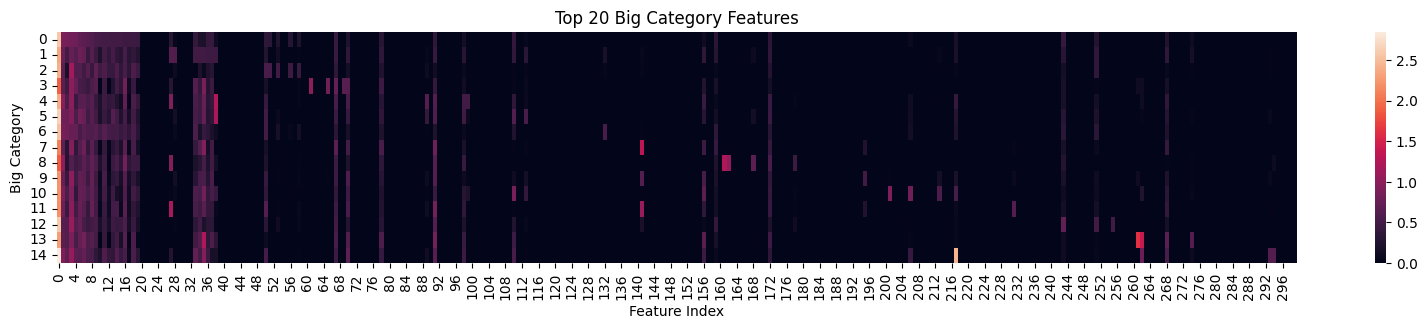

In [18]:
import numpy as np 
import seaborn as sns

top_k = 20
all_indices = []
category_top_k_indices = {}
category_top_k_values = { }
category_means = { }
all_mean = feature_counts.mean(dim=0)
for cat, indices in big_category_indices.items():
    # select samples 
    selected_feature_counts = feature_counts[indices]
    mean = torch.mean(selected_feature_counts, dim=0)
    
    # select top k features
    top_k_results = torch.topk(mean, k=top_k, dim=0)
    top_k_mean_indices = top_k_results.indices
    
    all_indices.extend(top_k_mean_indices.tolist())
    category_top_k_indices[cat] = top_k_mean_indices.tolist()
    category_means[cat] = mean.tolist()
    

heatmap_data = np.zeros((len(big_categories), len(all_indices)))
for i, (cat, indices) in enumerate(category_top_k_indices.items()):
    for j_count, j in enumerate(all_indices):
        new_index = all_indices.index(j)
        heatmap_data[i, new_index] = category_means[cat][j]
        
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
sns.heatmap(heatmap_data)
plt.title(f'Top {top_k} Big Category Features')
plt.xlabel('Feature Index')
plt.ylabel('Big Category')
plt.savefig(f'assets/top_{top_k}_big_category_features.png', dpi=300, bbox_inches='tight')
plt.show()

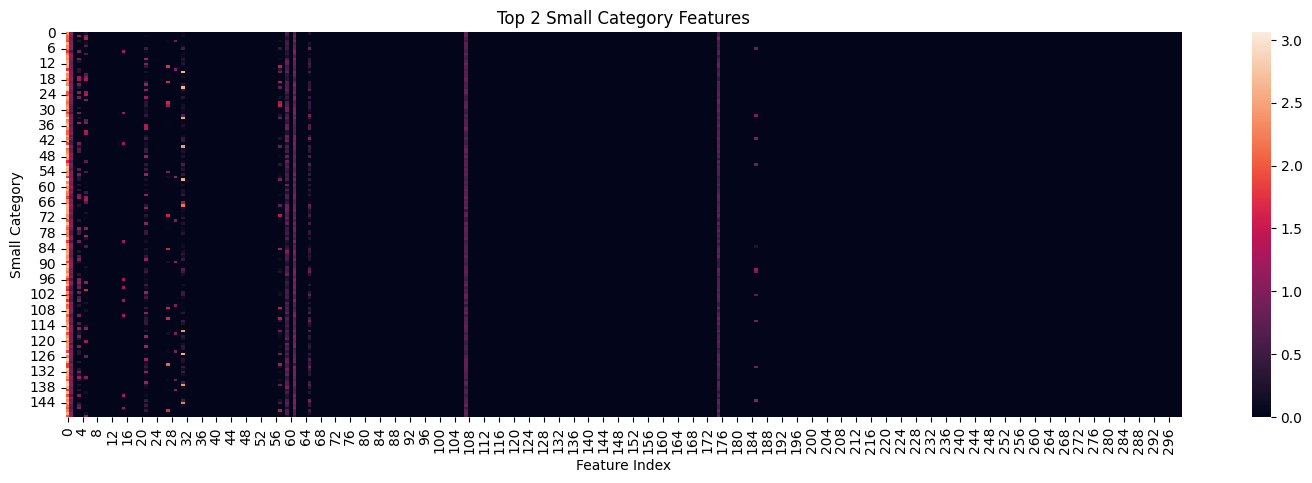

In [21]:

import numpy as np 
import seaborn as sns


top_k = 2
all_indices = []
category_top_k_indices = {}
category_top_k_values = { }
category_means = { }

all_mean = feature_counts.mean(dim=0)
for cat, indices in small_category_indices.items():
    # select samples 
    selected_feature_counts = feature_counts[indices]
    mean = torch.mean(selected_feature_counts, dim=0)
    
    # select top k features
    top_k_results = torch.topk(mean, k=top_k, dim=0)
    top_k_mean_indices = top_k_results.indices
    
    all_indices.extend(top_k_mean_indices.tolist())
    category_top_k_indices[cat] = top_k_mean_indices.tolist()
    category_means[cat] = mean.tolist()
    
    # add sample data 
heatmap_data = np.zeros((len(small_categories), len(all_indices)))
for i, (cat, indices) in enumerate(category_top_k_indices.items()):
    for j_count, j in enumerate(all_indices):
        new_index = all_indices.index(j)
        heatmap_data[i, new_index] = category_means[cat][j]
        
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
sns.heatmap(heatmap_data)
plt.title('Top 2 Small Category Features')
plt.xlabel('Feature Index')
plt.ylabel('Small Category')
plt.savefig(f'assets/top_{top_k}_small_category_features.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
sample_data = np.zeros((len(custom_data), len(all_indices)))
for i, data in enumerate(custom_data):
    sample_data[i] = feature_counts[i, all_indices]

labels_to_integer = {label: i for i, label in enumerate(small_categories)}
labels = [labels_to_integer[data['small_category']] for data in custom_data]
labels = np.array(labels)
print(sample_data.shape, labels.shape)

(1500, 600) (1500,)


100%|██████████| 500/500 [00:00<00:00, 561.96it/s]


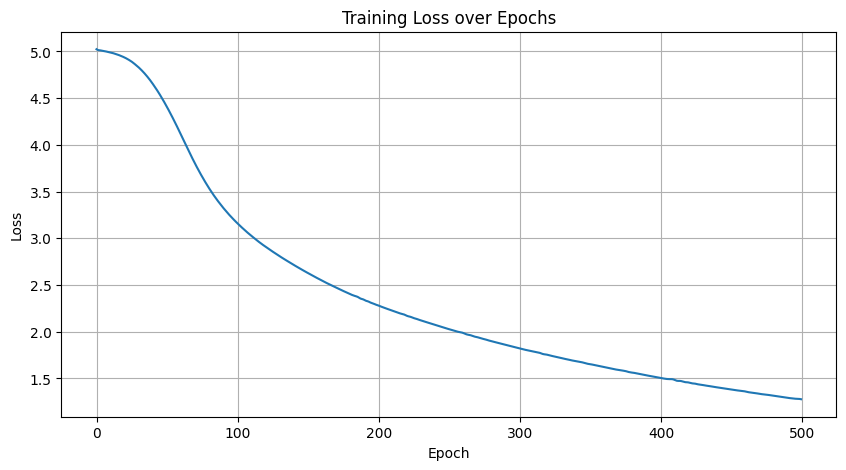

Final accuracy: 0.6133


In [9]:
# Convert data to PyTorch tensors
X = torch.FloatTensor(sample_data)
y = torch.LongTensor(labels)

# Define the model
class ThreeLayerNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(ThreeLayerNet, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size1)
        self.layer2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = torch.nn.Linear(hidden_size2, num_classes)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize model, loss, and optimizer
input_size = X.shape[1]
hidden_size1 = 64
hidden_size2 = 32
num_classes = len(small_categories)

model = ThreeLayerNet(input_size, hidden_size1, hidden_size2, num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 500
losses = []

for epoch in tqdm(range(epochs)):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Calculate accuracy
with torch.no_grad():
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y).sum().item() / y.size(0)
    print(f'Final accuracy: {accuracy:.4f}')